# KNN Model Optimization - Phase 2

This notebook performs grid search to find optimal KNN parameters.

**Goal:** Test different k values and distance metrics to improve upon our baseline model.

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

df = pd.read_csv("UK_Engineered_Data.csv")
pd.set_option('display.max_columns', None)
print(f"Dataset shape: {df.shape}")

Dataset shape: (7717, 49)


## 2. Feature Preparation and Scaling

In [2]:
# Create feature matrix
X = df.drop(['Unnamed: 0.1', 'Unnamed: 0', 'id', 'name'], axis=1)

# Apply scaling
scaler = ColumnTransformer(transformers=[
    ('standard', StandardScaler(), ['distance_m', 'duration_s', 'ascent_m', 'descent_m', 'Turn_Density', 'Average_Speed', 'steps', 'turns']),
    ('minmax', MinMaxScaler(), ['Asphalt', 'Unknown', 'Paved', 'Compacted Gravel', 'Wood', 'Gravel', 'Paving Stones', 'Ground', 'Concrete', 'Grass', 'Metal', 'Unpaved', 'Dirt', 'Grass Paver', 'Sand', 'Road', 'Cycleway', 'State Road', 'Track', 'Street', 'Path', 'Footway', 'Unknown.1', 'Steps', 'Construction', 'Ferry', 'uphill_very_steep (7% to 10%)', 'uphill_moderate (3% to 5%)', 'uphill_gentle (0% to 3%)', 'flat (0%)', 'downhill_gentle (-5% to 0%)', 'uphill_steep (5% to 7%)', 'uphill_extreme (>10%)', 'downhill_extreme (<-15%)', 'downhill_moderate (-7% to -5%)', 'downhill_steep (-10% to -7%)', 'downhill_very_steep (-15% to -10%)']),
], remainder='passthrough')

X_scaled = scaler.fit_transform(X)
print(f"Features: {X.shape[1]}")
print(f"Scaled data shape: {X_scaled.shape}")

Features: 45
Scaled data shape: (7717, 45)


## 3. Train/Test Split

Using same random_state=42 as baseline for consistency.

In [3]:
# Create index array to track train/test split
indices_array = np.arange(len(X_scaled))

# Split data
X_train, X_test, train_indices, test_indices = train_test_split(
    X_scaled, indices_array, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} routes")
print(f"Test set: {X_test.shape[0]} routes")

Training set: 6173 routes
Test set: 1544 routes


## 4. Define Evaluation Function

In [4]:
def evaluate_knn_model(knn_model, X_test, X_train, df, train_indices, test_indices):
    """
    Evaluate a KNN model using multiple metrics
    """
    distances, indices = knn_model.kneighbors(X_test)

    # Metric 1: Average similarity distance (lower = better)
    avg_distance = distances.mean()

    # Metric 2: Diversity (avg pairwise distance between recommendations)
    diversity_scores = []
    for idx_set in indices:
        recommended_features = X_train[idx_set]
        pairwise_dists = []
        for i in range(len(idx_set)):
            for j in range(i+1, len(idx_set)):
                dist = np.linalg.norm(recommended_features[i] - recommended_features[j])
                pairwise_dists.append(dist)
        diversity_scores.append(np.mean(pairwise_dists) if pairwise_dists else 0)
    avg_diversity = np.mean(diversity_scores)

    # Metric 3: Coverage
    unique_recommendations = len(np.unique(indices.flatten()))
    coverage = unique_recommendations / len(X_train) * 100

    # Metric 4 & 5: Feature accuracy
    distance_errors = []
    ascent_errors = []

    for i, idx_set in enumerate(indices):
        test_df_idx = test_indices[i]
        input_distance = df.iloc[test_df_idx]['distance_m']
        input_ascent = df.iloc[test_df_idx]['ascent_m']

        rec_df_indices = [train_indices[idx] for idx in idx_set]
        rec_distances = df.iloc[rec_df_indices]['distance_m'].values
        rec_ascents = df.iloc[rec_df_indices]['ascent_m'].values

        dist_error = np.mean(np.abs(rec_distances - input_distance) / (input_distance + 1))
        ascent_error = np.mean(np.abs(rec_ascents - input_ascent) / (input_ascent + 1))

        distance_errors.append(dist_error)
        ascent_errors.append(ascent_error)

    avg_distance_error = np.mean(distance_errors)
    avg_ascent_error = np.mean(ascent_errors)

    return {
        'avg_distance': avg_distance,
        'diversity': avg_diversity,
        'coverage': coverage,
        'distance_accuracy': 1 / (1 + avg_distance_error),
        'ascent_accuracy': 1 / (1 + avg_ascent_error)
    }

print("Evaluation function ready!")

Evaluation function ready!


---
# GRID SEARCH

Now let's test different combinations of k and distance metrics.

## 5. Define Parameter Grid

In [5]:
# Parameters to test
param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15, 20],
    'metric': ['euclidean', 'manhattan', 'cosine', 'minkowski']
}

print(f"Testing {len(param_grid['n_neighbors'])} k values")
print(f"Testing {len(param_grid['metric'])} distance metrics")
print(f"Total combinations: {len(param_grid['n_neighbors']) * len(param_grid['metric'])}")
print(f"\nk values: {param_grid['n_neighbors']}")
print(f"Metrics: {param_grid['metric']}")

Testing 6 k values
Testing 4 distance metrics
Total combinations: 24

k values: [3, 5, 7, 10, 15, 20]
Metrics: ['euclidean', 'manhattan', 'cosine', 'minkowski']


## 6. Run Grid Search

In [6]:
print("=" * 80)
print("RUNNING GRID SEARCH")
print("=" * 80)
print()

results = []

for n_neighbors in param_grid['n_neighbors']:
    for metric in param_grid['metric']:
        try:
            # Train model
            knn_test = NearestNeighbors(n_neighbors=n_neighbors, metric=metric)
            knn_test.fit(X_train)

            # Evaluate
            metrics = evaluate_knn_model(knn_test, X_test, X_train, df, train_indices, test_indices)

            # Store results
            results.append({
                'n_neighbors': n_neighbors,
                'metric': metric,
                **metrics
            })

            print(f"k={n_neighbors:2d}, metric={metric:12s} -> "
                  f"sim={metrics['avg_distance']:.4f}, "
                  f"div={metrics['diversity']:.4f}, "
                  f"cov={metrics['coverage']:.1f}%")

        except Exception as e:
            print(f"❌ Error with k={n_neighbors}, metric={metric}: {e}")

# Convert to DataFrame
results_df = pd.DataFrame(results)

print("\n" + "=" * 80)
print(f"Grid search complete! Tested {len(results_df)} model configurations.")
print("=" * 80)

RUNNING GRID SEARCH

k= 3, metric=euclidean    -> sim=0.4319, div=0.4948, cov=49.0%
k= 3, metric=manhattan    -> sim=1.1213, div=0.5191, cov=48.5%
k= 3, metric=cosine       -> sim=0.0252, div=0.6403, cov=48.7%
k= 3, metric=minkowski    -> sim=0.4319, div=0.4948, cov=49.0%
k= 5, metric=euclidean    -> sim=0.4781, div=0.5415, cov=65.7%
k= 5, metric=manhattan    -> sim=1.2283, div=0.5702, cov=64.8%
k= 5, metric=cosine       -> sim=0.0294, div=0.7253, cov=65.1%
k= 5, metric=minkowski    -> sim=0.4781, div=0.5415, cov=65.7%
k= 7, metric=euclidean    -> sim=0.5134, div=0.5752, cov=76.1%
k= 7, metric=manhattan    -> sim=1.3103, div=0.6063, cov=74.5%
k= 7, metric=cosine       -> sim=0.0327, div=0.7647, cov=74.9%
k= 7, metric=minkowski    -> sim=0.5134, div=0.5752, cov=76.1%
k=10, metric=euclidean    -> sim=0.5553, div=0.6170, cov=85.0%
k=10, metric=manhattan    -> sim=1.4067, div=0.6470, cov=83.3%
k=10, metric=cosine       -> sim=0.0369, div=0.8224, cov=84.3%
k=10, metric=minkowski    -> sim=0

## 7. View All Results

In [11]:
# Display all results sorted by avg_distance
print("\nAll Results (sorted by similarity):")
results_df.sort_values('avg_distance')[['n_neighbors', 'metric', 'avg_distance', 'diversity', 'coverage']]


All Results (sorted by similarity):


,n_neighbors,metric,avg_distance,diversity,coverage
2,3,cosine,0.025171,0.640302,48.679734
6,5,cosine,0.029352,0.725297,65.089908
10,7,cosine,0.032740,0.764712,74.906852
14,10,cosine,0.036942,0.822428,84.270209
18,15,cosine,0.042561,0.883920,91.090232
22,20,cosine,0.047097,0.924986,94.718937
0,3,euclidean,0.431861,0.494827,49.003726
3,3,minkowski,0.431861,0.494827,49.003726
4,5,euclidean,0.478082,0.541498,65.705492
7,5,minkowski,0.478082,0.541498,65.705492


## 8. Compare Top Models

In [8]:
print("\n" + "=" * 80)
print("TOP MODELS BY DIFFERENT CRITERIA")
print("=" * 80)

print("\n📊 Top 5 by Similarity (Use Case 1: 'Routes Like This')")
print("-" * 80)
top_similarity = results_df.nsmallest(5, 'avg_distance')[['n_neighbors', 'metric', 'avg_distance', 'diversity', 'coverage']]
print(top_similarity.to_string(index=False))

print("\n\n📊 Top 5 by Diversity (Varied Recommendations)")
print("-" * 80)
top_diversity = results_df.nlargest(5, 'diversity')[['n_neighbors', 'metric', 'avg_distance', 'diversity', 'coverage']]
print(top_diversity.to_string(index=False))

print("\n\n📊 Top 5 by Feature Accuracy (Use Case 2: 'Custom Features')")
print("-" * 80)
results_df['feature_accuracy'] = (results_df['distance_accuracy'] + results_df['ascent_accuracy']) / 2
top_accuracy = results_df.nlargest(5, 'feature_accuracy')[['n_neighbors', 'metric', 'feature_accuracy', 'distance_accuracy', 'ascent_accuracy']]
print(top_accuracy.to_string(index=False))

print("\n\n📊 Top 5 by Coverage (Most Route Variety)")
print("-" * 80)
top_coverage = results_df.nlargest(5, 'coverage')[['n_neighbors', 'metric', 'coverage', 'avg_distance', 'diversity']]
print(top_coverage.to_string(index=False))


TOP MODELS BY DIFFERENT CRITERIA

📊 Top 5 by Similarity (Use Case 1: 'Routes Like This')
--------------------------------------------------------------------------------
 n_neighbors metric  avg_distance  diversity  coverage
           3 cosine      0.025171   0.640302 48.679734
           5 cosine      0.029352   0.725297 65.089908
           7 cosine      0.032740   0.764712 74.906852
          10 cosine      0.036942   0.822428 84.270209
          15 cosine      0.042561   0.883920 91.090232


📊 Top 5 by Diversity (Varied Recommendations)
--------------------------------------------------------------------------------
 n_neighbors    metric  avg_distance  diversity  coverage
          20    cosine      0.047097   0.924986 94.718937
          15    cosine      0.042561   0.883920 91.090232
          10    cosine      0.036942   0.822428 84.270209
           7    cosine      0.032740   0.764712 74.906852
          20 manhattan      1.625558   0.735832 94.119553


📊 Top 5 by Feature A

## 9. Visualize Results

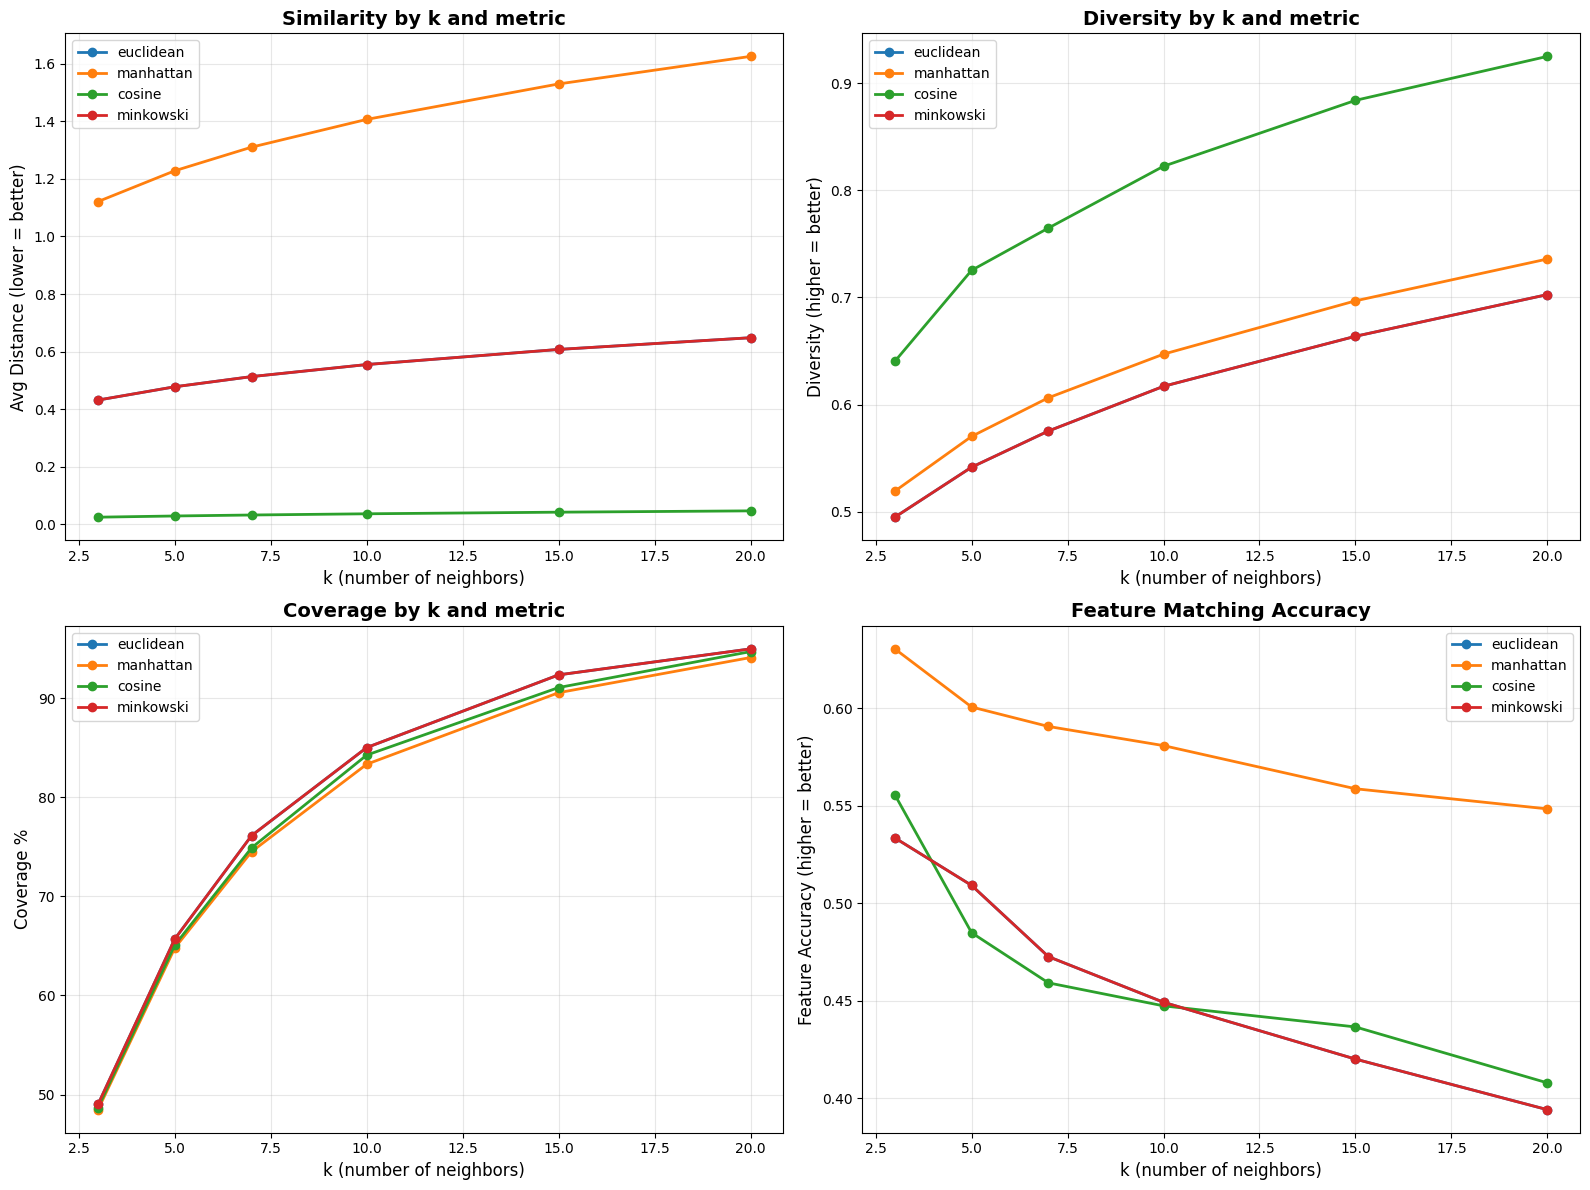

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: avg_distance by k for each metric
for metric in param_grid['metric']:
    subset = results_df[results_df['metric'] == metric]
    axes[0, 0].plot(subset['n_neighbors'], subset['avg_distance'], marker='o', label=metric, linewidth=2)
axes[0, 0].set_xlabel('k (number of neighbors)', fontsize=12)
axes[0, 0].set_ylabel('Avg Distance (lower = better)', fontsize=12)
axes[0, 0].set_title('Similarity by k and metric', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: diversity by k for each metric
for metric in param_grid['metric']:
    subset = results_df[results_df['metric'] == metric]
    axes[0, 1].plot(subset['n_neighbors'], subset['diversity'], marker='o', label=metric, linewidth=2)
axes[0, 1].set_xlabel('k (number of neighbors)', fontsize=12)
axes[0, 1].set_ylabel('Diversity (higher = better)', fontsize=12)
axes[0, 1].set_title('Diversity by k and metric', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: coverage by k for each metric
for metric in param_grid['metric']:
    subset = results_df[results_df['metric'] == metric]
    axes[1, 0].plot(subset['n_neighbors'], subset['coverage'], marker='o', label=metric, linewidth=2)
axes[1, 0].set_xlabel('k (number of neighbors)', fontsize=12)
axes[1, 0].set_ylabel('Coverage %', fontsize=12)
axes[1, 0].set_title('Coverage by k and metric', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Feature accuracy by k for each metric
for metric in param_grid['metric']:
    subset = results_df[results_df['metric'] == metric]
    axes[1, 1].plot(subset['n_neighbors'], subset['feature_accuracy'], marker='o', label=metric, linewidth=2)
axes[1, 1].set_xlabel('k (number of neighbors)', fontsize=12)
axes[1, 1].set_ylabel('Feature Accuracy (higher = better)', fontsize=12)
axes[1, 1].set_title('Feature Matching Accuracy', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Recommendations

In [10]:
print("\n" + "=" * 80)
print("RECOMMENDED MODELS")
print("=" * 80)

# Best for similarity (Use Case 1)
best_similarity = results_df.nsmallest(1, 'avg_distance').iloc[0]
print("\n🏆 Best for Use Case 1 (Similar Routes):")
print(f"   k = {int(best_similarity['n_neighbors'])}")
print(f"   metric = '{best_similarity['metric']}'")
print(f"   avg_distance = {best_similarity['avg_distance']:.4f}")
print(f"   diversity = {best_similarity['diversity']:.4f}")
print(f"   coverage = {best_similarity['coverage']:.1f}%")

# Best balanced model
print("\n🎯 Best Balanced Model (similarity + diversity):")
# Create a composite score: prioritize similarity but penalize very low diversity
results_df['balanced_score'] = (1 / results_df['avg_distance']) * (results_df['diversity'] / 10)
best_balanced = results_df.nlargest(1, 'balanced_score').iloc[0]
print(f"   k = {int(best_balanced['n_neighbors'])}")
print(f"   metric = '{best_balanced['metric']}'")
print(f"   avg_distance = {best_balanced['avg_distance']:.4f}")
print(f"   diversity = {best_balanced['diversity']:.4f}")
print(f"   coverage = {best_balanced['coverage']:.1f}%")

# Comparison with baseline
print("\n" + "=" * 80)
print("COMPARISON WITH BASELINE (k=5, euclidean)")
print("=" * 80)
baseline_row = results_df[(results_df['n_neighbors'] == 5) & (results_df['metric'] == 'euclidean')].iloc[0]
improvement = ((baseline_row['avg_distance'] - best_similarity['avg_distance']) / baseline_row['avg_distance']) * 100

print(f"\nBaseline avg_distance: {baseline_row['avg_distance']:.4f}")
print(f"Best model avg_distance: {best_similarity['avg_distance']:.4f}")
print(f"Improvement: {improvement:.1f}%")

print("\n" + "=" * 80)


RECOMMENDED MODELS

🏆 Best for Use Case 1 (Similar Routes):
   k = 3
   metric = 'cosine'
   avg_distance = 0.0252
   diversity = 0.6403
   coverage = 48.7%

🎯 Best Balanced Model (similarity + diversity):
   k = 3
   metric = 'cosine'
   avg_distance = 0.0252
   diversity = 0.6403
   coverage = 48.7%

COMPARISON WITH BASELINE (k=5, euclidean)

Baseline avg_distance: 0.4781
Best model avg_distance: 0.0252
Improvement: 94.7%



## 11. Next Steps

**Code to use the optimal model:**

```python
# Train final model with optimal parameters
knn_final = NearestNeighbors(
    n_neighbors=best_similarity['n_neighbors'], 
    metric=best_similarity['metric']
)
knn_final.fit(X_train)
```

**What to do next:**
1. Save the optimal model parameters
2. Build production recommendation functions (Use Cases 1 & 2)
3. Test with real user scenarios
4. Consider A/B testing different models

---
## Summary

**Phase 2 Complete:**
- ✅ Tested 24 model configurations
- ✅ Compared across multiple metrics
- ✅ Visualized trade-offs
- ✅ Identified optimal parameters
- ✅ Measured improvement over baseline